Hello! Welcome to this quick down and dirty notebook. As the competition progresses, this will get built out and have a little more text added. For now, just something to get you started. Feature engineering from the engine column. 

# 1.0 Imports

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

# 2.0 Load Data and Get High Level View

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e9/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e9/test.csv")

In [3]:
pd.set_option('display.max_columns', None)
train_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


In [5]:
categorical_columns = train_df.select_dtypes(include=['object']).columns
unique_values_per_column = train_df[categorical_columns].nunique()
print(unique_values_per_column)

brand             57
model           1897
fuel_type          7
engine          1117
transmission      52
ext_col          319
int_col          156
accident           2
clean_title        1
dtype: int64


In [6]:
pd.set_option('display.max_columns', None)
test_df.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


In [8]:
def count_unique_words(df, column):
    all_text = ' '.join(df[column].dropna().astype(str).str.lower())
    words = all_text.split()
    word_counts = Counter(words)
    word_count_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Count'])
    word_count_df = word_count_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return word_count_df


# 3.0 Data Analysis
## 3.1 Brand and Model Interaction

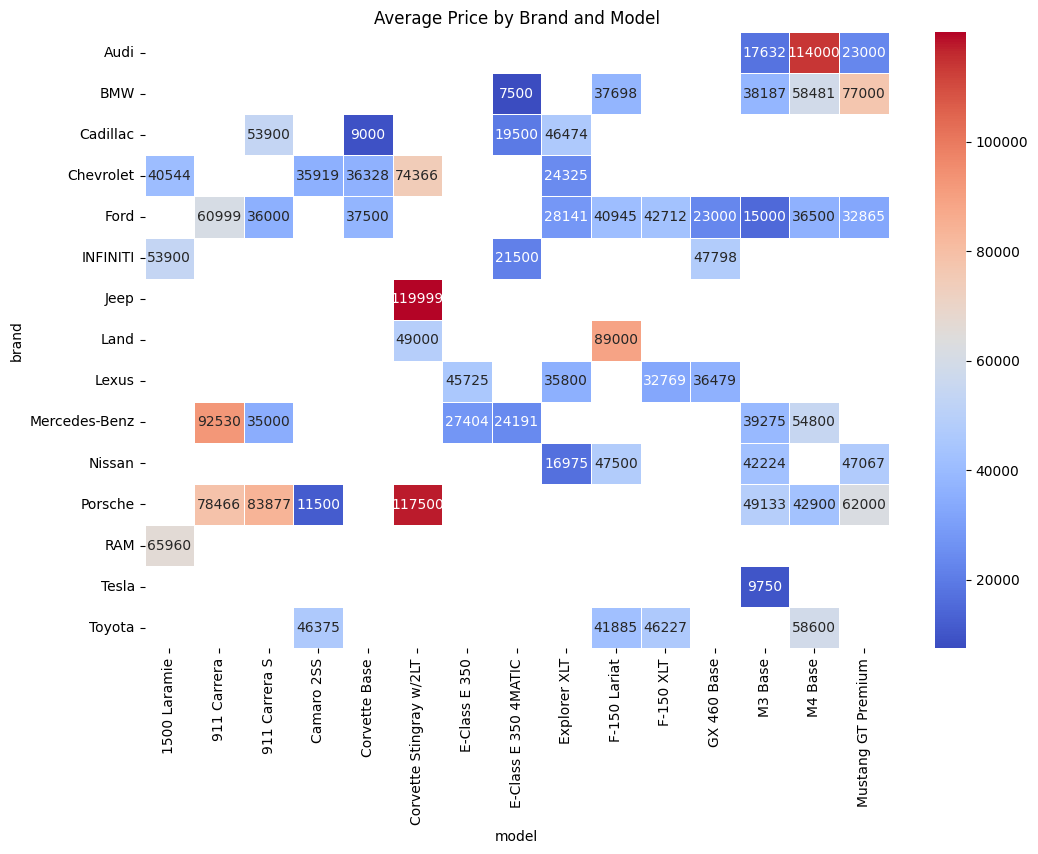

In [9]:
df = train_df 

top_brands = df['brand'].value_counts().nlargest(15).index
top_models = df['model'].value_counts().nlargest(15).index

df_filtered = df[(df['brand'].isin(top_brands)) & (df['model'].isin(top_models))]
pivot_table = df_filtered.pivot_table(index='brand', columns='model', values='price', aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.0f', linewidths=0.5)
plt.title('Average Price by Brand and Model')
plt.show()


# 4.0 Data Cleaning
## 4.1 Initial Thoughts
- We will need a way to handle nan values, break apart these model names, engine names, internal and external colors. 
- Can we pull horsepower out of the engine column and make that its own column? 
    - Model is going to be a tough column to crack, maybe we could train a separate regressor on the model’s name and have that be an input.
    - This will take some time, should be saved for last. 
- Color could probably be broken up into a top 15 category and another category.
    - If we're training in modelling, could we also just train on color? 
    - Is color even useful without the other information? 
- We should also check out continuous variables for any outliers. 
- Add in miles/year traveled. 

## 4.2 Engine

In [10]:
def extract_engine_info(df):
    column = 'engine'

    hp_pattern = r'(\d+\.?\d*)HP'
    l_pattern = r'(\d+\.?\d*)\s*[lL](iter)?'  
    cylinder_pattern = r'(\d+)\sCylinder'
    v_pattern = r'[vV](\d+)'  
    before_v_pattern = r'(\d+)[vV]'  
    turbo_pattern = r'Turbo'  
    dohc_pattern = r'\bDOHC\b'
    gdi_pattern = r'\bGDI\b'
    mpfi_pattern = r'\bMPFI\b'
    pdi_pattern = r'\bPDI\b'
    ohv_pattern = r'\bOHV\b'

    df['HP'] = df[column].apply(lambda x: re.search(hp_pattern, x).group(1) if re.search(hp_pattern, x) else None)
    df['L'] = df[column].apply(lambda x: re.search(l_pattern, x).group(1) if re.search(l_pattern, x) else None)
    df['Cylinder'] = df[column].apply(lambda x: re.search(cylinder_pattern, x).group(1) if re.search(cylinder_pattern, x) else None)
    df['V_'] = df[column].apply(lambda x: re.search(v_pattern, x).group(1) if re.search(v_pattern, x) else None)
    df['_V'] = df[column].apply(lambda x: re.search(before_v_pattern, x).group(1) if re.search(before_v_pattern, x) else None)
    df['Turbo'] = df[column].apply(lambda x: bool(re.search(turbo_pattern, x, re.IGNORECASE)))  
    df['DOHC'] = df[column].apply(lambda x: bool(re.search(dohc_pattern, x, re.IGNORECASE)))
    df['GDI'] = df[column].apply(lambda x: bool(re.search(gdi_pattern, x, re.IGNORECASE)))
    df['MPFI'] = df[column].apply(lambda x: bool(re.search(mpfi_pattern, x, re.IGNORECASE)))
    df['PDI'] = df[column].apply(lambda x: bool(re.search(pdi_pattern, x, re.IGNORECASE)))
    df['OHV'] = df[column].apply(lambda x: bool(re.search(ohv_pattern, x, re.IGNORECASE)))

    def remove_patterns(text):
        text = re.sub(hp_pattern, '', text)  
        text = re.sub(l_pattern, '', text)   
        text = re.sub(cylinder_pattern, '', text) 
        text = re.sub(fuel_pattern, '', text)  
        text = re.sub(v_pattern, '', text)   
        text = re.sub(before_v_pattern, '', text)  
        text = re.sub(turbo_pattern, '', text, flags=re.IGNORECASE)  
        text = re.sub(r'\bengine\b', '', text, flags=re.IGNORECASE)  
        text = re.sub(dohc_pattern, '', text, flags=re.IGNORECASE)  
        text = re.sub(gdi_pattern, '', text, flags=re.IGNORECASE)  
        text = re.sub(mpfi_pattern, '', text, flags=re.IGNORECASE)  
        text = re.sub(pdi_pattern, '', text, flags=re.IGNORECASE) 
        text = re.sub(ohv_pattern, '', text, flags=re.IGNORECASE)  
        return text.strip()  

    # df['engine_new'] = df[column].apply(remove_patterns)

    return df

Excellent! 5 new continuous variables and 6 one-hot-encoded columns.

## 4.3 Transmission

In [11]:
def transmission (df):
    def extract_gears(transmission):
        match = re.search(r'(\d+)(?:[\s-]*Speed)?', transmission, re.IGNORECASE)
        if match:
            return match.group(1)
        return 0
    
    df['is_automatic'] = df['transmission'].str.contains(r'Automatic|A/T', case=False)
    df['is_manual'] = df['transmission'].str.contains(r'Manual|M/T', case=False)
    df['is_cvt'] = df['transmission'].str.contains(r'CVT|Variable', case=False)
    df['gears'] = df['transmission'].apply(extract_gears)
    df['has_overdrive'] = df['transmission'].str.contains(r'Overdrive', case=False)
    df['has_dual_shift'] = df['transmission'].str.contains(r'Dual Shift Mode', case=False)
    df['is_electronically_controlled'] = df['transmission'].str.contains(r'Electronically Controlled', case=False)
    df['is_dct'] = df['transmission'].str.contains(r'DCT', case=False)
    df['is_other'] = df['transmission'].str.contains(r'^(?:SCHEDULED FOR OR IN PRODUCTION|F|–|Transmission Overdrive Switch)$', case=False)
    return df

Great! 1 new continuou variable and 8 one-hot-encoded columns.

## 4.4 Accident, Fuel Type, and Clean-Title

In [12]:
def fuel_type(df):
    df['fuel_type'] = df['fuel_type'].replace(['not supported', '–', np.nan], 'Other')
    df_encoded = pd.get_dummies(df['fuel_type'], prefix='fuel_type', dtype=bool)
    df = pd.concat([df, df_encoded], axis=1)
    df['accident_reported'] = df['accident'].apply(lambda x: True if x == 'At least 1 accident or damage reported' else False)
    df['clean_title_boolean'] = df['clean_title'].apply(lambda x: True if x == 'Yes' else False)
    return df

## 4.5 Missing Values

In [13]:
def fill_missing_values(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    continuous_columns = df.select_dtypes(include=['int64']).columns

    df[categorical_columns] = df[categorical_columns].fillna('missing')
    df[continuous_columns] = df[continuous_columns].fillna(0)
    
    return df

In [14]:
# word_count_table = count_unique_words(train_df, 'model')
# pd.set_option('display.max_rows', None)
# print(word_count_table)